# 🌴 S4GAN Salak Segmentation - Inference (Multi-Head)
### Semi-supervised Semantic Segmentation for Salak Dataset

**Architecture:** DeepLabV3+ Multi-Head with ResNet-50 backbone (3 Heads)

**Features:**
- ✅ Load models from Google Drive
- ✅ Load images from Google Drive
- ✅ Patch-based inference with overlap handling
- ✅ Merge patches back to full image
- ✅ Visualization with color mapping
- ✅ Save predictions to Drive

## 1️⃣ Setup and Installation

## 2️⃣ Mount Google Drive

In [1]:
# ==============================================================
# ✅ Clean, Safe, One-Cell Setup for Colab (with Private GitHub)
# ==============================================================

import os, sys, site
from google.colab import drive, userdata

# 0️⃣ Reset to safe directory
os.chdir("/content")
print("📂 Working directory:", os.getcwd())

# 1️⃣ Clean any previous environments/repositories
!rm -rf /content/env /content/diversenet-salak

# 2️⃣ Create new isolated environment
!pip install virtualenv --quiet
!virtualenv /content/env -p python3

# 3️⃣ Activate virtualenv for current Python session
site.addsitedir("/content/env/lib/python3.12/site-packages")
sys.path.insert(0, "/content/env/lib/python3.12/site-packages")
os.environ["VIRTUAL_ENV"] = "/content/env"
os.environ["PATH"] = "/content/env/bin:" + os.environ["PATH"]
print("✅ Virtual environment active at:", os.environ["VIRTUAL_ENV"])

# 4️⃣ Install compatible dependencies (Added smp & patchify)
!pip install -U pip wheel setuptools --quiet
!pip install numpy==1.26.4 pillow==10.3.0 torch torchvision torchaudio \
               opencv-python-headless albumentations patchify segmentation-models-pytorch --quiet

📂 Working directory: /content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 41.6 MB/s eta 0:00:00
created virtual environment CPython3.12.12.final.0-64 in 248ms
  creator CPython3Posix(dest=/content/env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.3
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
✅ Virtual environment active at: /content/env


In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

Mounted at /content/drive
✅ Google Drive mounted successfully!


## 3️⃣ Configuration
**📝 Update these paths according to your Google Drive structure**

In [3]:
CONFIG = {
    # Model settings
    "NUM_CLASSES": 7,
    "OUTPUT_STRIDE": 16,
    "NUM_HEADS": 3,

    # Patch settings
    "PATCH_SIZE": 256,
    "PATCH_STEP": 220,

    # Paths
    "base_path": "/content/drive/MyDrive/SalakSegDataset",
    "checkpoint_path": "/content/drive/MyDrive/SalakSegDataset/save_model/s4gan-salak/best_model_ema.pth",
    "class_mapping_csv": "/content/drive/MyDrive/SalakSegDataset/class_mapping.csv",
    "test_images_dir": "/content/drive/MyDrive/SalakSegDataset/test_images/images",
    "ground_truth_dir": "/content/drive/MyDrive/SalakSegDataset/test_images/ground_truth",
    "output_dir": "/content/drive/MyDrive/SalakSegDataset/predictions",
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("🔧 Configuration:")
print("="*60)
for key, value in CONFIG.items():
    print(f"  {key:25s}: {value}")
print("="*60)

🔧 Configuration:
  NUM_CLASSES              : 7
  OUTPUT_STRIDE            : 16
  NUM_HEADS                : 3
  PATCH_SIZE               : 256
  PATCH_STEP               : 220
  base_path                : /content/drive/MyDrive/SalakSegDataset
  checkpoint_path          : /content/drive/MyDrive/SalakSegDataset/save_model/s4gan-salak/best_model_ema.pth
  class_mapping_csv        : /content/drive/MyDrive/SalakSegDataset/class_mapping.csv
  test_images_dir          : /content/drive/MyDrive/SalakSegDataset/test_images/images
  ground_truth_dir         : /content/drive/MyDrive/SalakSegDataset/test_images/ground_truth
  output_dir               : /content/drive/MyDrive/SalakSegDataset/predictions


## 4️⃣ Define DeepLabV3+ Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from tqdm.auto import tqdm

# ============================
# ASPP Module
# ============================

class ASPPConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(ASPPConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                             padding=dilation, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        size = x.shape[-2:]
        x = self.gap(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=True)


class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=256, output_stride=16):
        super(ASPP, self).__init__()

        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = ASPPConv(in_channels, out_channels, dilations[1])
        self.conv3 = ASPPConv(in_channels, out_channels, dilations[2])
        self.conv4 = ASPPConv(in_channels, out_channels, dilations[3])
        self.pool = ASPPPooling(in_channels, out_channels)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        res.append(self.conv1(x))
        res.append(self.conv2(x))
        res.append(self.conv3(x))
        res.append(self.conv4(x))
        res.append(self.pool(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

print("✅ ASPP module defined")

✅ ASPP module defined


In [11]:
import torchvision.models as models

# ============================
# Multi-Head DeepLabV3+
# ============================

class MultiHeadDeepLabV3Plus(nn.Module):
    """DeepLabV3+ with 3 classification heads for diversity"""
    def __init__(self, n_classes, num_heads=3, output_stride=16, pretrained_backbone=False):
        super(MultiHeadDeepLabV3Plus, self).__init__()

        self.n_classes = n_classes
        self.num_heads = num_heads

        # ResNet50 backbone
        resnet = models.resnet50(pretrained=pretrained_backbone)

        self.layer0 = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.layer1 = resnet.layer1  # 256 channels
        self.layer2 = resnet.layer2  # 512 channels
        self.layer3 = resnet.layer3  # 1024 channels
        self.layer4 = resnet.layer4  # 2048 channels

        # Modify layer4 for output_stride=16
        if output_stride == 16:
            self._make_layer_dilated(self.layer4, dilation=2, stride=1)

        # ASPP
        self.aspp = ASPP(in_channels=2048, out_channels=256, output_stride=output_stride)

        # Low-level feature projection
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(256, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        # Shared decoder backbone
        self.decoder_backbone = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),  # 256 + 48 = 304
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Multiple classification heads
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(0.1 + 0.05 * i),
                nn.Conv2d(256, n_classes, 1)
            ) for i in range(num_heads)
        ])

    def _make_layer_dilated(self, layer, dilation, stride=1):
        """Convert layer to use dilated convolutions"""
        for i, block in enumerate(layer):
            if hasattr(block, 'conv2'):
                if block.conv2.stride == (2, 2) and i == 0:
                    block.conv2.stride = (stride, stride)
                    block.conv2.dilation = (dilation, dilation)
                    block.conv2.padding = (dilation, dilation)
                    if block.downsample is not None:
                        block.downsample[0].stride = (stride, stride)
                else:
                    block.conv2.dilation = (dilation, dilation)
                    block.conv2.padding = (dilation, dilation)

    def forward(self, x, return_all_heads=False):
        input_size = x.shape[-2:]

        # Encoder
        x = self.layer0(x)
        low_level = self.layer1(x)
        x = self.layer2(low_level)
        x = self.layer3(x)
        x = self.layer4(x)

        # ASPP
        x = self.aspp(x)

        # Decoder
        low_level = self.low_level_conv(low_level)
        x = F.interpolate(x, size=low_level.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, low_level], dim=1)
        features = self.decoder_backbone(x)

        # Multiple heads
        outputs = [head(features) for head in self.heads]

        # Upsample all heads
        outputs = [F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
                   for out in outputs]

        if return_all_heads:
            return outputs
        else:
            # Mean voting (ensemble)
            return torch.stack(outputs).mean(dim=0)

print("✅ MultiHeadDeepLabV3Plus architecture defined")

✅ MultiHeadDeepLabV3Plus architecture defined


## 5️⃣ Import Libraries and Setup

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from patchify import patchify
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image

# Import Segmentation Models Pytorch
import segmentation_models_pytorch as smp

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️  Using device: cuda
   GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.17 GB


## 6️⃣ Load Color Mapping

In [13]:
# Load class mapping CSV
print(f"📋 Loading color mapping from: {CONFIG['class_mapping_csv']}")
mapping = pd.read_csv(CONFIG['class_mapping_csv'])
mapping["rgb"] = mapping["class_color"].apply(lambda s: tuple(map(int, s.split())))

# Create color map (ID -> RGB)
color_map = {i: tuple(row["rgb"]) for i, row in mapping.iterrows()}

# Create reverse map (RGB -> ID) for processing Ground Truth
rgb_to_id = {tuple(row["rgb"]): i for i, row in mapping.iterrows()}

# RGB to name mapping for display
RGB_TO_COLOR_NAME = {
    (0, 0, 0): "black",
    (255, 50, 50): "red",
    (255, 225, 50): "yellow",
    (109, 255, 50): "lime green",
    (50, 255, 167): "aqua",
    (50, 167, 255): "sky blue",
    (109, 50, 255): "violet"
}

print(f"\n✅ Loaded color map for {len(color_map)} classes:")
print("="*60)
for i, (cls_name, color) in enumerate(zip(mapping["class_name"], mapping["rgb"])):
    cname = RGB_TO_COLOR_NAME.get(tuple(color), "Unknown")
    print(f"  Class {i}: {cls_name:<20} → RGB {tuple(color)} ({cname})")
print("="*60)

📋 Loading color mapping from: /content/drive/MyDrive/SalakSegDataset/class_mapping.csv

✅ Loaded color map for 7 classes:
  Class 0: __background__       → RGB (0, 0, 0) (black)
  Class 1: Badan Air            → RGB (255, 50, 50) (red)
  Class 2: Bangunan             → RGB (255, 225, 50) (yellow)
  Class 3: Jalan                → RGB (109, 255, 50) (lime green)
  Class 4: Pohon Berinang       → RGB (50, 255, 167) (aqua)
  Class 5: Snake Fruit          → RGB (50, 167, 255) (sky blue)
  Class 6: Tanah Terbuka        → RGB (109, 50, 255) (violet)


## 8️⃣ Load S4GAN Model

In [14]:
# Create Multi-Head model
print("🏗️  Building Multi-Head DeepLabV3+ model...")
model = MultiHeadDeepLabV3Plus(
    n_classes=CONFIG['NUM_CLASSES'],
    num_heads=CONFIG['NUM_HEADS'],
    output_stride=CONFIG['OUTPUT_STRIDE'],
    pretrained_backbone=False
)

# Load checkpoint
print(f"📂 Loading checkpoint: {CONFIG['checkpoint_path']}")
checkpoint = torch.load(CONFIG['checkpoint_path'], map_location=device)

# Handle DataParallel
if list(checkpoint.keys())[0].startswith('module.'):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:]  # remove 'module.'
        new_state_dict[name] = v
    checkpoint = new_state_dict

model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model loaded successfully!")
print(f"📊 Total parameters: {total_params:,}")
print(f"💾 Memory: ~{total_params * 4 / 1024**2:.1f} MB (FP32)")

🏗️  Building Multi-Head DeepLabV3+ model...


/content/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/content/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


📂 Loading checkpoint: /content/drive/MyDrive/SalakSegDataset/save_model/s4gan-salak/best_model_ema.pth
✅ Model loaded successfully!
📊 Total parameters: 40,352,181
💾 Memory: ~153.9 MB (FP32)


## 9️⃣ Define Inference Function

⚠️ **CRITICAL:** Training uses **BGR mean subtraction**, NOT ImageNet normalization!
- Training preprocessing: `image (BGR) - [104.007, 116.669, 122.679]`
- NO division by std!
- Image must stay in BGR format (cv2 default)

In [ ]:
# BGR Mean used in training (important: BGR order, not RGB!)
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

print("⚠️  IMPORTANT: Using BGR mean subtraction (matching training)")
print(f"   BGR Mean: {IMG_MEAN}")

# Custom transform that matches training preprocessing
def preprocess_patch(patch_bgr):
    """Apply same preprocessing as training: BGR mean subtraction"""
    # Convert to float
    patch_float = patch_bgr.astype(np.float32)
    # Subtract BGR mean (no division by std!)
    patch_float -= IMG_MEAN
    # Convert to tensor and change from HWC to CHW
    patch_tensor = torch.from_numpy(patch_float).permute(2, 0, 1)
    return patch_tensor

def infer_full_image(image_path, model, patch_size, step, n_classes, device, verbose=True):
    if verbose:
        print(f"\n🖼️  Loading: {os.path.basename(image_path)}")

    # Load as BGR (cv2 default) - DO NOT convert to RGB!
    image = cv2.imread(image_path)
    H, W, _ = image.shape

    if verbose:
        print(f"📏 Size: {W} x {H}")

    n_patches_h = (H - patch_size) // step + 1
    n_patches_w = (W - patch_size) // step + 1
    if (n_patches_h - 1) * step + patch_size < H:
        n_patches_h += 1
    if (n_patches_w - 1) * step + patch_size < W:
        n_patches_w += 1

    if verbose:
        print(f"📦 Patches: {n_patches_h} x {n_patches_w} = {n_patches_h * n_patches_w}")

    accumulated_probs = np.zeros((n_classes, H, W), dtype=np.float32)
    overlap_counter = np.zeros((H, W), dtype=np.float32)

    model.eval()
    with torch.no_grad():
        iterator = range(n_patches_h)
        if verbose:
            iterator = tqdm(range(n_patches_h), desc="Processing")

        for i in iterator:
            for j in range(n_patches_w):
                y_start = i * step
                x_start = j * step
                y_end = min(y_start + patch_size, H)
                x_end = min(x_start + patch_size, W)

                # Ensure the last patch fully covers the boundary if needed by shifting start
                if y_end == H and (y_start + patch_size > H):
                    y_start = H - patch_size
                if x_end == W and (x_start + patch_size > W):
                    x_start = W - patch_size

                patch = image[y_start:y_end, x_start:x_end, :]

                # Pad patch if it's smaller than patch_size (e.g., at borders)
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    pad_h = patch_size - patch.shape[0]
                    pad_w = patch_size - patch.shape[1]
                    patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

                # Apply training preprocessing (BGR mean subtraction)
                tensor_patch = preprocess_patch(patch).unsqueeze(0).to(device)

                # Forward (ensemble of 3 heads)
                logits = model(tensor_patch, return_all_heads=False)
                probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

                # Crop back to the original (non-padded) patch dimensions
                probs = probs[:, :(y_end - y_start), :(x_end - x_start)]

                accumulated_probs[:, y_start:y_end, x_start:x_end] += probs
                overlap_counter[y_start:y_end, x_start:x_end] += 1.0

    # Ensure no division by zero for pixels that might not have been covered
    overlap_counter[overlap_counter == 0] = 1.0

    avg_probs = accumulated_probs / overlap_counter
    pred_mask = np.argmax(avg_probs, axis=0).astype(np.uint8)
    confidence_map = np.max(avg_probs, axis=0).astype(np.float32)

    if verbose:
        print(f"✅ Complete! Confidence: {confidence_map.mean():.3f}")

    return pred_mask, confidence_map, avg_probs

print("✅ Inference function defined")

✅ Inference function defined


## 📊 Step 7: Metrics

In [16]:
def fast_hist(a, b, n):
    k = (b >= 0) & (b < n)
    return np.bincount(n * b[k].astype(int) + a[k], minlength=n ** 2).reshape(n, n)

def compute_all_metrics(hist):
    ious = np.diag(hist) / np.maximum((hist.sum(1) + hist.sum(0) - np.diag(hist)), 1)
    prod_acc = np.diag(hist) / hist.sum(axis=1)
    user_acc = np.diag(hist) / hist.sum(axis=0)
    f1 = 2 * (prod_acc * user_acc) / (prod_acc + user_acc + 1e-10)

    return {
        'ious': ious,
        'miou': np.nanmean(ious),
        'pixel_accuracy': np.diag(hist).sum() / hist.sum(),
        'producer_accuracy': prod_acc,
        'user_accuracy': user_acc,
        'f1_score': f1,
        'mean_producer_acc': np.nanmean(prod_acc),
        'mean_user_acc': np.nanmean(user_acc),
        'mean_f1': np.nanmean(f1)
    }

print("✅ Metrics defined")

✅ Metrics defined


## 🔟 Define Visualization Functions

In [17]:
def visualize_results(image_path, pred_mask, confidence_map, color_map, mapping,
                     alpha=0.35, save_path=None, gt_mask=None):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if img.shape[:2] != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        confidence_map = cv2.resize(confidence_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
        if gt_mask is not None:
            gt_mask = cv2.resize(gt_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    color_pred = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        mask = (pred_mask == class_id)
        color_pred[mask] = color

    color_gt = None
    if gt_mask is not None:
        color_gt = np.zeros((*gt_mask.shape, 3), dtype=np.uint8)
        for class_id, color in color_map.items():
            mask = (gt_mask == class_id)
            color_gt[mask] = color

    overlay = cv2.addWeighted(img.astype(np.float32), 1 - alpha,
                             color_pred.astype(np.float32), alpha, 0).astype(np.uint8)

    plt.figure(figsize=(24, 12))

    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title("Original", fontsize=16, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    if color_gt is not None:
        plt.imshow(color_gt)
        plt.title("Ground Truth", fontsize=16, fontweight='bold')
    else:
        plt.text(0.5, 0.5, "No GT", ha='center')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(color_pred)
    plt.title("Prediction", fontsize=16, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(overlay)
    plt.title("Overlay", fontsize=16, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(confidence_map, cmap='jet', vmin=0, vmax=1)
    plt.colorbar(label='Confidence', fraction=0.046)
    plt.title("Confidence", fontsize=16, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.axis('off')
    y_pos = 0.9
    plt.text(0.1, 0.95, "Legend:", fontsize=14, fontweight='bold')
    for cls_id, color in color_map.items():
        cname = mapping.iloc[cls_id]['class_name'] if cls_id < len(mapping) else "Unknown"
        c_norm = [c/255.0 for c in color]
        plt.text(0.1, y_pos, f"█ {cls_id}: {cname}", color=c_norm, fontsize=12, fontweight='bold')
        y_pos -= 0.07

    plt.tight_layout()
    plt.show()

    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        cv2.imwrite(save_path.replace('.png', '_mask.png'), cv2.cvtColor(color_pred, cv2.COLOR_RGB2BGR))
        print(f"💾 Saved: {save_path}")

    return overlay

print("✅ Visualization defined")

✅ Visualization defined


## 1️⃣1️⃣ Run Inference on Single Image

In [18]:
# ============================
# Select an image to test
# ============================

# Option 1: Specify image path directly
# test_image_path = "/content/drive/MyDrive/DiverseNet/test_images/DJI_0286.JPG"

# Option 2: List all images in test_images_dir and select one
test_images = sorted([f for f in os.listdir(CONFIG['test_images_dir'])
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
print(f"Found {len(test_images)} test images")
test_image_path = os.path.join(CONFIG['test_images_dir'], test_images[2])

print(f"🎯 Testing on: {test_image_path}")

# Check if file exists
if os.path.exists(test_image_path):
    print("✅ Image found!")
else:
    print("❌ Image not found! Please check the path.")
    print(f"   Looking for: {test_image_path}")

Found 5 test images
🎯 Testing on: /content/drive/MyDrive/SalakSegDataset/test_images/images/DJI_0414.JPG
✅ Image found!


In [ ]:
# Run inference
pred_mask, confidence_map, class_probs = infer_full_image(
    test_image_path, model,
    CONFIG['PATCH_SIZE'], CONFIG['PATCH_STEP'],
    CONFIG['NUM_CLASSES'], device
)

# Apply confidence filtering for over-predicted classes
print("\n🔧 Applying confidence-based post-processing...")
filtered_mask = apply_confidence_filter(
    pred_mask, confidence_map, class_probs,
    min_confidence=0.6,
    suspicious_classes=[1],  # Badan Air is over-predicted
    fallback_class=0  # Assign to background if unsure
)

# Replace pred_mask with filtered version for metrics
pred_mask_original = pred_mask.copy()
pred_mask = filtered_mask


🖼️  Loading: DJI_0414.JPG
📏 Size: 4000 x 3000
📦 Patches: 14 x 19 = 266


Processing: 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]


✅ Complete! Confidence: 0.999


In [20]:
# Load GT if exists
base_name = os.path.splitext(os.path.basename(test_image_path))[0]
gt_files = os.listdir(CONFIG['ground_truth_dir'])
gt_match = next((f for f in gt_files if os.path.splitext(f)[0] == base_name), None)

gt_mask = None
if gt_match:
    gt_path = os.path.join(CONFIG['ground_truth_dir'], gt_match)
    gt_mask_raw = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)

    if gt_mask_raw is not None:
        if gt_mask_raw.shape[:2] != pred_mask.shape:
            gt_mask_raw = cv2.resize(gt_mask_raw, (pred_mask.shape[1], pred_mask.shape[0]),
                                    interpolation=cv2.INTER_NEAREST)

        if len(gt_mask_raw.shape) == 3:
            gt_rgb = cv2.cvtColor(gt_mask_raw, cv2.COLOR_BGR2RGB)
            gt_mask = np.zeros(gt_mask_raw.shape[:2], dtype=np.uint8)
            for rgb_val, cls_id in rgb_to_id.items():
                match_mask = np.all(gt_rgb == rgb_val, axis=-1)
                gt_mask[match_mask] = cls_id
        else:
            gt_mask = gt_mask_raw

        # Metrics
        hist = fast_hist(gt_mask.flatten(), pred_mask.flatten(), CONFIG['NUM_CLASSES'])
        metrics = compute_all_metrics(hist)

        print(f"\n📊 Metrics:")
        print(f"  mIoU: {metrics['miou']:.4f}")
        print(f"  Overall Acc: {metrics['pixel_accuracy']:.4f}")
        print(f"  Mean PA: {metrics['mean_producer_acc']:.4f}")
        print(f"  Mean UA: {metrics['mean_user_acc']:.4f}")
        print(f"  Mean F1: {metrics['mean_f1']:.4f}")

        # Debug: Show class distribution
        print(f"\n🔍 Class Distribution:")
        print(f"  Prediction: {np.bincount(pred_mask.flatten(), minlength=CONFIG['NUM_CLASSES'])}")
        print(f"  Ground Truth: {np.bincount(gt_mask.flatten(), minlength=CONFIG['NUM_CLASSES'])}")


📊 Metrics:
  mIoU: 0.0001
  Overall Acc: 0.0000
  Mean PA: 0.0075
  Mean UA: 0.0001
  Mean F1: 0.0008

🔍 Class Distribution:
  Prediction: [       0 11989145        0    10855        0        0        0]
  Ground Truth: [2283120       0 2649620  378942   17670 6466738  203910]


/tmp/ipython-input-1215890683.py:7: RuntimeWarning: invalid value encountered in divide
  prod_acc = np.diag(hist) / hist.sum(axis=1)
/tmp/ipython-input-1215890683.py:8: RuntimeWarning: invalid value encountered in divide
  user_acc = np.diag(hist) / hist.sum(axis=0)


In [ ]:
# Analyze prediction quality
print("\n📊 Prediction Analysis:")
print(f"  Average confidence: {confidence_map.mean():.3f}")
print(f"  Min confidence: {confidence_map.min():.3f}")
print(f"  Max confidence: {confidence_map.max():.3f}")

# Per-class confidence
print(f"\n📈 Per-Class Average Confidence:")
for cls_id in range(CONFIG['NUM_CLASSES']):
    cls_mask = (pred_mask == cls_id)
    if cls_mask.sum() > 0:
        avg_conf = confidence_map[cls_mask].mean()
        pixel_count = cls_mask.sum()
        cls_name = mapping.iloc[cls_id]['class_name']
        print(f"  Class {cls_id} ({cls_name}): {avg_conf:.3f} ({pixel_count:,} pixels)")

# Show if post-processing made changes
if 'pred_mask_original' in locals():
    changes = (pred_mask_original != pred_mask).sum()
    print(f"\n🔧 Post-processing changed {changes:,} pixels ({changes/pred_mask.size*100:.2f}%)")

## 🔧 (Optional) Post-Processing: Confidence Thresholding

**Issue:** Model over-predicting Class 1 (Badan Air) due to class imbalance in training.

**Solution:** Apply minimum confidence threshold - if prediction confidence is below threshold, assign to most likely alternative class or background.

In [ ]:
def apply_confidence_filter(pred_mask, confidence_map, class_probs, min_confidence=0.6, 
                           suspicious_classes=[1], fallback_class=0):
    """
    Apply confidence-based filtering to suspicious classes.
    
    Args:
        pred_mask: Predicted class mask (H, W)
        confidence_map: Max confidence per pixel (H, W)
        class_probs: All class probabilities (C, H, W)
        min_confidence: Minimum confidence threshold
        suspicious_classes: Classes to apply filtering (e.g., [1] for Badan Air)
        fallback_class: Class to assign if confidence too low (0 for background)
    
    Returns:
        Filtered prediction mask
    """
    filtered_mask = pred_mask.copy()
    
    for cls in suspicious_classes:
        # Find pixels predicted as this class
        cls_mask = (pred_mask == cls)
        low_conf_mask = (confidence_map < min_confidence)
        
        # Find pixels with low confidence for this class
        suspicious_pixels = cls_mask & low_conf_mask
        
        if suspicious_pixels.sum() > 0:
            # For these pixels, check second best class
            for y in range(pred_mask.shape[0]):
                for x in range(pred_mask.shape[1]):
                    if suspicious_pixels[y, x]:
                        probs = class_probs[:, y, x]
                        # Get top 2 classes
                        top_classes = np.argsort(probs)[-2:][::-1]
                        
                        # If second best is much better than background, use it
                        if top_classes[1] != fallback_class and probs[top_classes[1]] > 0.2:
                            filtered_mask[y, x] = top_classes[1]
                        else:
                            filtered_mask[y, x] = fallback_class
            
            print(f"  ⚠️  Filtered {suspicious_pixels.sum():,} low-confidence pixels for class {cls}")
    
    return filtered_mask

print("✅ Post-processing functions defined")

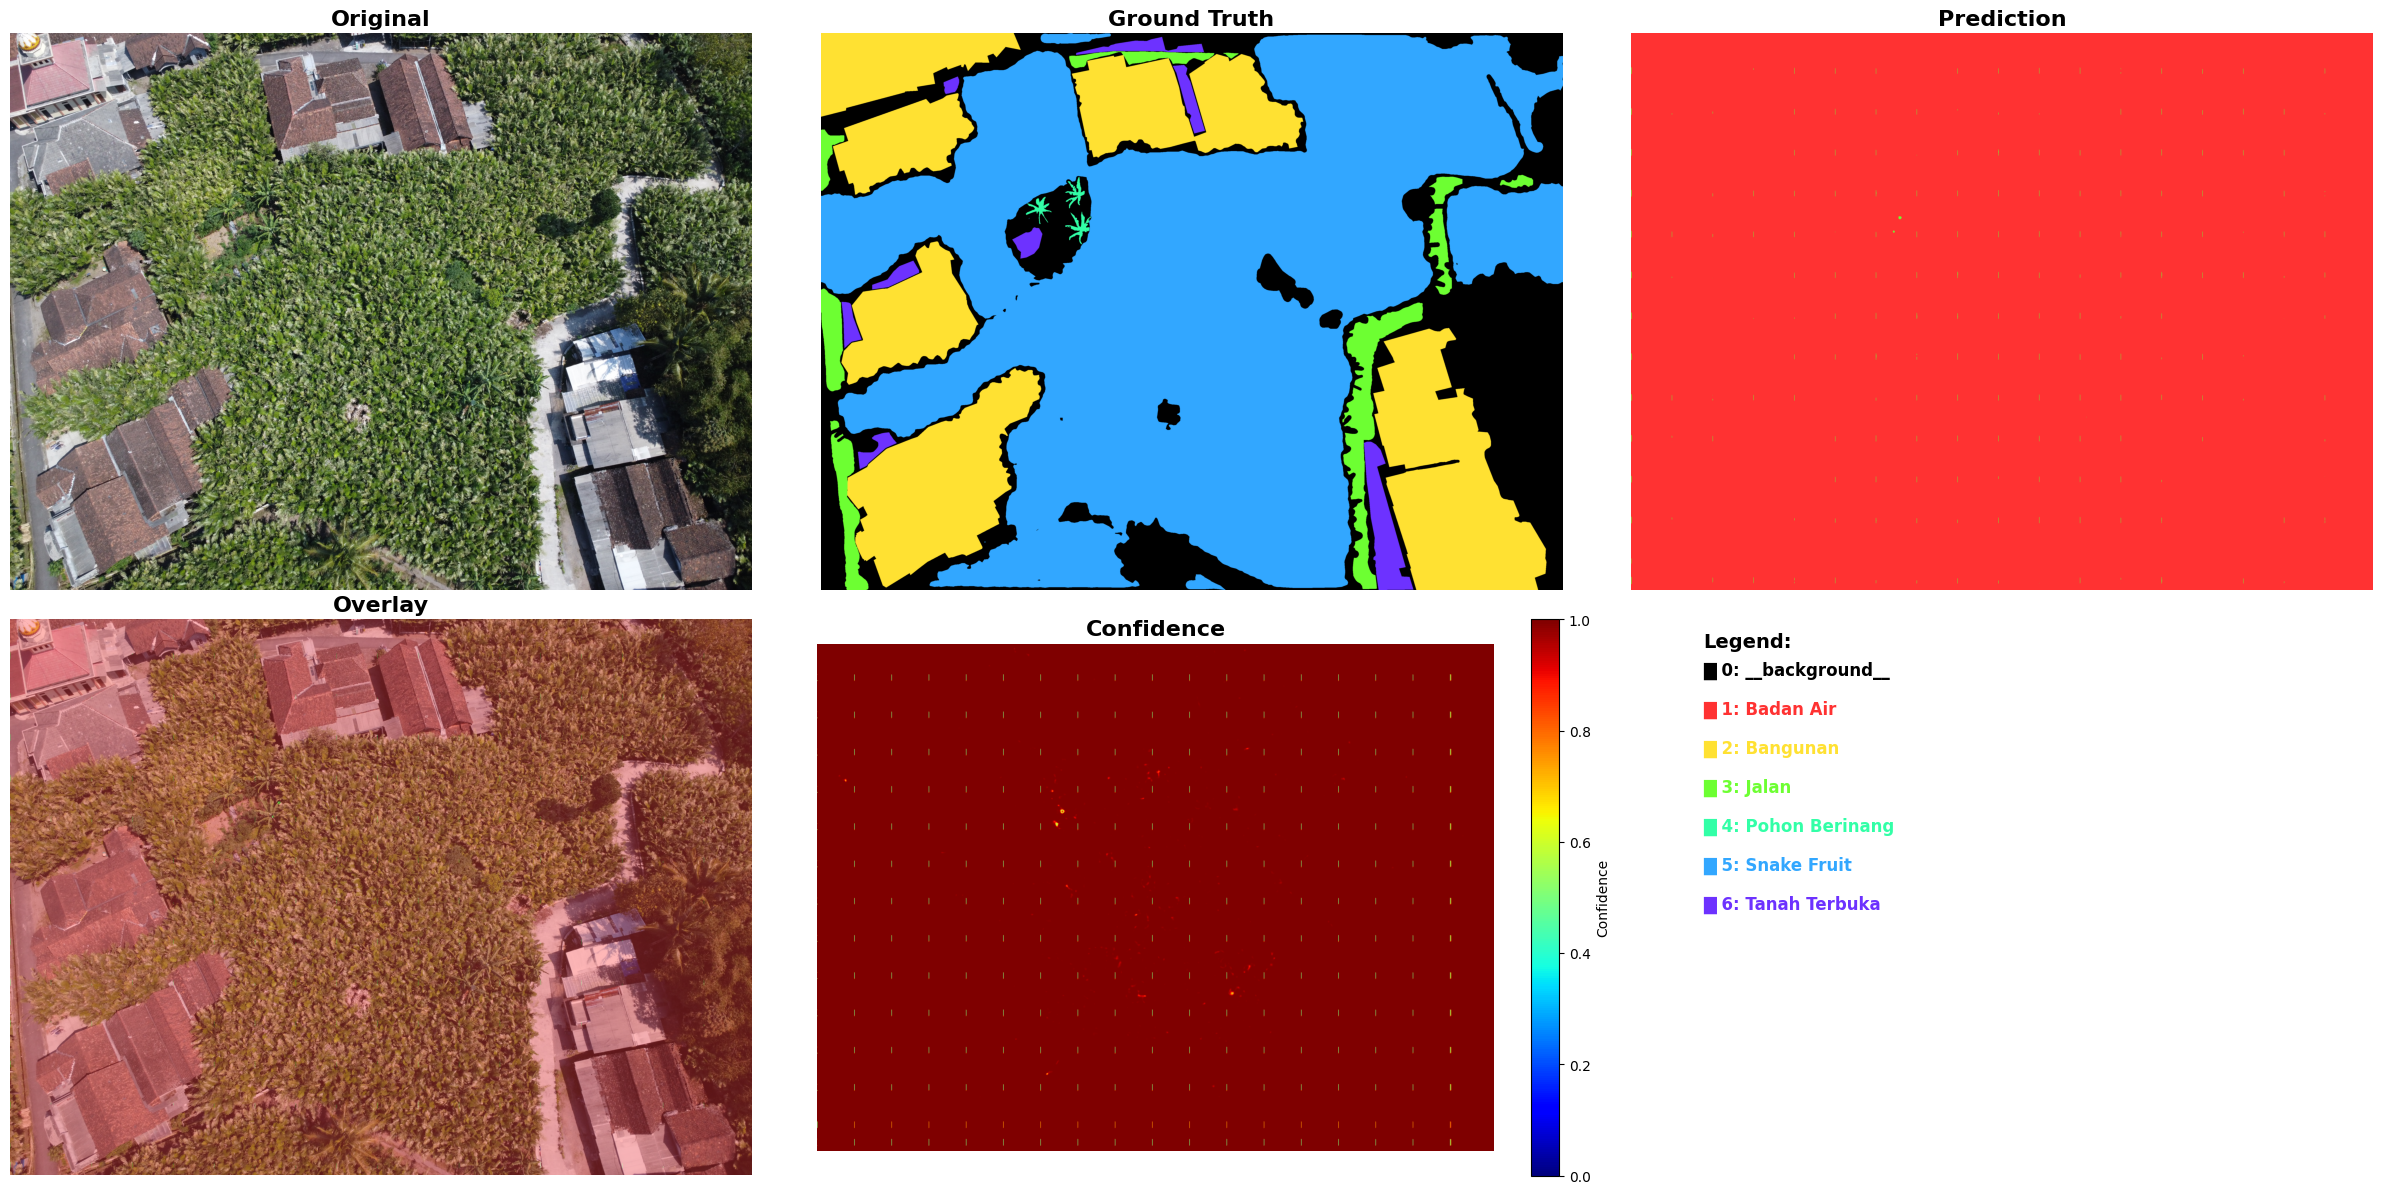

💾 Saved: /content/drive/MyDrive/SalakSegDataset/predictions/DJI_0414_overlay.png


array([[[171,  85,  89],
        [173,  87,  90],
        [172,  85,  89],
        ...,
        [158,  92,  59],
        [142,  75,  40],
        [144,  77,  40]],

       [[175,  89,  92],
        [177,  90,  94],
        [174,  88,  90],
        ...,
        [151,  85,  51],
        [152,  85,  50],
        [147,  81,  44]],

       [[171,  85,  87],
        [173,  87,  89],
        [171,  85,  87],
        ...,
        [139,  72,  40],
        [145,  77,  44],
        [156,  89,  53]],

       ...,

       [[195, 127,  96],
        [187, 120,  87],
        [199, 133,  98],
        ...,
        [ 97,  28,  30],
        [ 99,  30,  32],
        [ 98,  29,  31]],

       [[190, 123,  92],
        [185, 118,  87],
        [197, 131,  96],
        ...,
        [ 97,  27,  29],
        [ 97,  28,  30],
        [ 95,  25,  27]],

       [[188, 122,  91],
        [198, 131, 100],
        [202, 136, 102],
        ...,
        [ 95,  25,  27],
        [ 95,  25,  27],
        [ 91,  22,  24]]

In [21]:
# Visualize
save_path = os.path.join(CONFIG['output_dir'],
                        os.path.basename(test_image_path).replace('.JPG', '_overlay.png').replace('.jpg', '_overlay.png'))

visualize_results(test_image_path, pred_mask, confidence_map, color_map, mapping,
                 alpha=0.35, save_path=save_path, gt_mask=gt_mask)

## 1️⃣2️⃣ Batch Inference on Multiple Images

In [ ]:
# Batch inference
image_files = sorted([f for f in os.listdir(CONFIG['test_images_dir'])
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

total_hist = np.zeros((CONFIG['NUM_CLASSES'], CONFIG['NUM_CLASSES']), dtype=np.float32)

print("="*110)
print(f"{'Image':<30} | {'mIoU':<8} | {'OA':<8} | {'PA':<8} | {'UA':<8} | {'F1':<8} | {'Status':<10}")
print("-" * 110)

for img_name in image_files:
    img_path = os.path.join(CONFIG['test_images_dir'], img_name)
    pred_mask, _, class_probs = infer_full_image(img_path, model,
                                    CONFIG['PATCH_SIZE'], CONFIG['PATCH_STEP'],
                                    CONFIG['NUM_CLASSES'], device, verbose=False)
    
    # Apply post-processing
    confidence_map_batch = np.max(class_probs, axis=0)
    pred_mask = apply_confidence_filter(pred_mask, confidence_map_batch, class_probs,
                                       min_confidence=0.6, suspicious_classes=[1], fallback_class=0)

    base_name = os.path.splitext(img_name)[0]
    gt_match = next((f for f in gt_files if os.path.splitext(f)[0] == base_name), None)

    if not gt_match:
        print(f"{img_name:<30} | {'N/A':<8} | {'N/A':<8} | {'N/A':<8} | {'N/A':<8} | {'N/A':<8} | ⚠️ No GT")
        continue

    gt_path = os.path.join(CONFIG['ground_truth_dir'], gt_match)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)

    if gt_mask is None:
        continue

    if gt_mask.shape[:2] != pred_mask.shape:
        gt_mask = cv2.resize(gt_mask, (pred_mask.shape[1], pred_mask.shape[0]),
                           interpolation=cv2.INTER_NEAREST)

    if len(gt_mask.shape) == 3:
        gt_rgb = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
        gt_mask_idx = np.zeros(gt_mask.shape[:2], dtype=np.uint8)
        for rgb_val, cls_id in rgb_to_id.items():
            match_mask = np.all(gt_rgb == rgb_val, axis=-1)
            gt_mask_idx[match_mask] = cls_id
        gt_mask = gt_mask_idx

    hist = fast_hist(gt_mask.flatten(), pred_mask.flatten(), CONFIG['NUM_CLASSES'])
    total_hist += hist

    metrics = compute_all_metrics(hist)

    print(f"{img_name:<30} | {metrics['miou']:.4f}   | {metrics['pixel_accuracy']:.4f}   | "
          f"{metrics['mean_producer_acc']:.4f}   | {metrics['mean_user_acc']:.4f}   | "
          f"{metrics['mean_f1']:.4f}   | ✅")

    cv2.imwrite(os.path.join(CONFIG['output_dir'], f"pred_{img_name.replace('.JPG', '.png').replace('.jpg', '.png')}"), pred_mask)

print("="*110)

Image                          | mIoU     | OA       | PA       | UA       | F1       | Status    
--------------------------------------------------------------------------------------------------------------


/tmp/ipython-input-1215890683.py:7: RuntimeWarning: invalid value encountered in divide
  prod_acc = np.diag(hist) / hist.sum(axis=1)
/tmp/ipython-input-1215890683.py:8: RuntimeWarning: invalid value encountered in divide
  user_acc = np.diag(hist) / hist.sum(axis=0)


DJI_0282.JPG                   | 0.0000   | 0.0000   | 0.0000   | 0.0000   | 0.0000   | ✅
DJI_0386.JPG                   | 0.0000   | 0.0000   | 0.0004   | 0.0000   | 0.0001   | ✅
DJI_0414.JPG                   | 0.0001   | 0.0000   | 0.0075   | 0.0001   | 0.0008   | ✅
DJI_0421.JPG                   | 0.0001   | 0.0006   | 0.0058   | 0.1429   | 0.0010   | ✅
DJI_0448.JPG                   | 0.0000   | 0.0000   | 0.0005   | 0.0001   | 0.0005   | ✅


## 📊 Step 11: Final Report

In [23]:
final_metrics = compute_all_metrics(total_hist)

print("\n" + "="*100)
print("📊 FINAL REPORT - S4GAN Multi-Head DeepLabV3+")
print("="*100)

print("\n🎯 OVERALL:")
print(f"  mIoU:              {final_metrics['miou']:.4f}")
print(f"  Overall Accuracy:  {final_metrics['pixel_accuracy']:.4f}")
print(f"  Mean Producer Acc: {final_metrics['mean_producer_acc']:.4f}")
print(f"  Mean User Acc:     {final_metrics['mean_user_acc']:.4f}")
print(f"  Mean F1:           {final_metrics['mean_f1']:.4f}")

print("\n📋 PER-CLASS:")
print("-" * 100)
print(f"{'ID':<3} | {'Class':<20} | {'IoU':<8} | {'PA':<8} | {'UA':<8} | {'F1':<8} | {'Area %':<8}")
print("-" * 100)

for i in range(CONFIG['NUM_CLASSES']):
    cname = mapping.iloc[i]['class_name']
    area = (total_hist[i, :].sum() / total_hist.sum()) * 100
    print(f"{i:<3} | {cname:<20} | {final_metrics['ious'][i]:.4f}   | "
          f"{final_metrics['producer_accuracy'][i]:.4f}   | "
          f"{final_metrics['user_accuracy'][i]:.4f}   | "
          f"{final_metrics['f1_score'][i]:.4f}   | {area:6.2f}%")

print("="*100)
print(f"\n✅ Done! Predictions: {CONFIG['output_dir']}")


📊 FINAL REPORT - S4GAN Multi-Head DeepLabV3+

🎯 OVERALL:
  mIoU:              0.0001
  Overall Accuracy:  0.0001
  Mean Producer Acc: 0.0026
  Mean User Acc:     0.1429
  Mean F1:           0.0004

📋 PER-CLASS:
----------------------------------------------------------------------------------------------------
ID  | Class                | IoU      | PA       | UA       | F1       | Area %  
----------------------------------------------------------------------------------------------------
0   | __background__       | 0.0000   | nan   | 0.0000   | nan   |   0.00%
1   | Badan Air            | 0.0001   | 0.0001   | 1.0000   | 0.0002   |  99.90%
2   | Bangunan             | 0.0000   | nan   | 0.0000   | nan   |   0.00%
3   | Jalan                | 0.0003   | 0.0051   | 0.0003   | 0.0006   |   0.10%
4   | Pohon Berinang       | 0.0000   | nan   | 0.0000   | nan   |   0.00%
5   | Snake Fruit          | 0.0000   | nan   | 0.0000   | nan   |   0.00%
6   | Tanah Terbuka        | 0.0000   | na

/tmp/ipython-input-1215890683.py:7: RuntimeWarning: invalid value encountered in divide
  prod_acc = np.diag(hist) / hist.sum(axis=1)


## 1️⃣3️⃣ (Optional) Visualize Patch Coverage

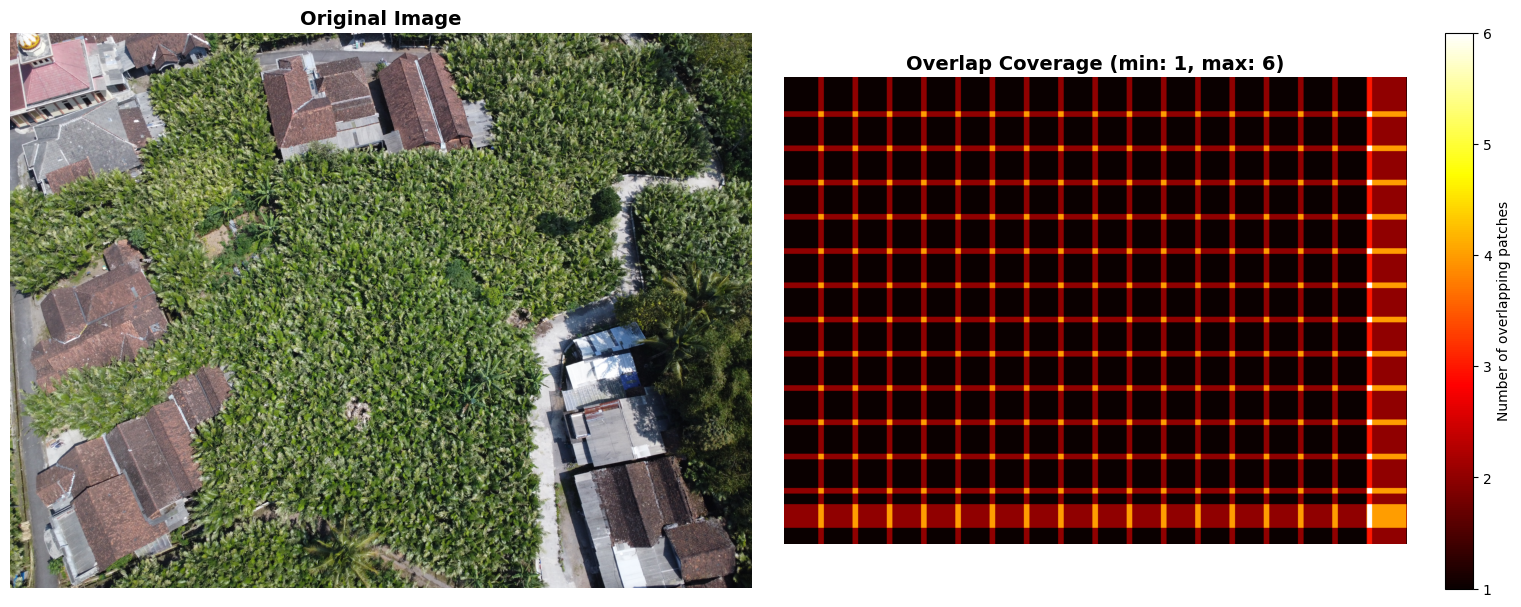


📊 Coverage Statistics:
  Minimum overlaps: 1
  Maximum overlaps: 6
  Average overlaps: 1.45
  Pixels with 0 coverage: 0


In [24]:
def visualize_patch_coverage(image_path, patch_size, step):
    """
    Visualize how patches overlap the image.
    Useful for debugging and understanding coverage.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img.shape

    # Create overlap heatmap
    overlap_map = np.zeros((H, W), dtype=np.int32)

    n_patches_h = (H - patch_size) // step + 1
    n_patches_w = (W - patch_size) // step + 1

    if (n_patches_h - 1) * step + patch_size < H:
        n_patches_h += 1
    if (n_patches_w - 1) * step + patch_size < W:
        n_patches_w += 1

    for i in range(n_patches_h):
        for j in range(n_patches_w):
            y_start = i * step
            x_start = j * step
            y_end = min(y_start + patch_size, H)
            x_end = min(x_start + patch_size, W)

            if y_end == H:
                y_start = max(0, H - patch_size)
            if x_end == W:
                x_start = max(0, W - patch_size)

            overlap_map[y_start:y_end, x_start:x_end] += 1

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image", fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlap_map, cmap='hot')
    plt.colorbar(label='Number of overlapping patches')
    plt.title(f"Overlap Coverage (min: {overlap_map.min()}, max: {overlap_map.max()})",
              fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Coverage Statistics:")
    print(f"  Minimum overlaps: {overlap_map.min()}")
    print(f"  Maximum overlaps: {overlap_map.max()}")
    print(f"  Average overlaps: {overlap_map.mean():.2f}")
    print(f"  Pixels with 0 coverage: {np.sum(overlap_map == 0)}")

# Visualize coverage
visualize_patch_coverage(test_image_path, CONFIG['PATCH_SIZE'], CONFIG['PATCH_STEP'])

## 1️⃣4️⃣ Summary and Next Steps

### ✅ What We've Done:
1. Loaded S4GAN Multi-Head model from Google Drive
2. Performed patch-based inference on full-resolution images
3. Merged overlapping patches with averaging
4. Visualized results with confidence maps
5. Saved predictions back to Google Drive

### 📊 Model Performance:
- **Architecture:** DeepLabV3+ with ResNet-50 + 3 Multi-Heads
- **Ensemble Strategy:** Mean voting from 3 diverse heads
- **Patch Overlap:** Improves boundary predictions

### 🔧 Adjustable Parameters:
- `PATCH_SIZE`: Larger = fewer patches but less detail
- `PATCH_STEP`: Smaller = more overlap = smoother but slower
- `alpha`: Overlay transparency (0.3-0.5 recommended)

### 📁 Output Files:
- `*_overlay.png`: Original image with segmentation overlay
- `*_mask.png`: Pure segmentation mask with class colors
- `pred_*.png`: Prediction masks for batch processing

### 🚀 Next Steps:
1. Evaluate on more test images
2. Compare predictions with ground truth metrics
3. Adjust patch overlap if boundaries look jagged
4. Analyze per-class performance for improvements

---

**Happy inferencing! 🎉**